# 05h  Understand outliers
- author Sylvie Dagoret-Campagne
- creation date : 2024/03/25
- last verification : 2024/03/25 (CCIN2P3 - kernel conda_desc_py310)

### Use libraries

- getObsAtmo : for atmosphere emulation : https://github.com/LSSTDESC/getObsAtmo/tree/main
- rubinsimphot : a simplified version of rubin_sim : https://github.com/sylvielsstfr/rubinsimphot

In [1]:
#! pip install ipympl
#conda install -c conda-forge ipympl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib ipympl
#%matplotlib widget
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import copy

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import getpass
import datetime

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
props = dict(boxstyle='round', facecolor='yellow', alpha=0.3)

# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [18, 10],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [3]:
from scipy import interpolate
from astropy import constants as const
from astropy import units as u
from joblib import dump, load

In [4]:
import warnings                      # imports the warnings library
import gc                            # imports python's garbage collector
# Ignore warnings
from astropy.units import UnitsWarning
warnings.simplefilter("ignore", category=UnitsWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from joblib import dump, load
import pickle

## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran emulator

In [5]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [6]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo()

LSST site name validated as LSST observatory


In [7]:
WL = emul.GetWL()

In [8]:
import sys
sys.path.append('../lib')
import libAtmosphericFit

LSST site name validated as LSST observatory


In [9]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


https://github.com/lsst/rubin_sim_notebooks/blob/main/photometry/calculating_snr.ipynb

In [10]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir
from rubinsimphot.phot_utils import PhotometricParameters 
from rubinsimphot.site_models import SeeingModel
from rubinsimphot.phot_utils import signaltonoise
from rubinsimphot.phot_utils import calc_neff

In [11]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [12]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [13]:
seeing_model = SeeingModel()
def seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=None, seeing_zenith=None):
    "Return FWHMeff in `obs_filter` at `obs_X`, providing either the seeing @ zenith (in filter) or the FWHM_500"
    if atmospheric_seeing_500nm is not None:
        idx = filterlist.index(obs_filter)
        fwhm_eff = seeing_model(atmospheric_seeing_500nm, obs_X)['fwhmEff'][idx]
    elif seeing_zenith is not None:
        # assume seeing_zenith is in the filter of choice and just approximate for airmass 
        airmass_correction = np.power(obs_X, 0.6)
        fwhm_eff = 1.16 * seeing_zenith * airmass_correction
    else:
        raise ValueErorr('Must specify atmospheric_seeing_500nm or seeing_zenith')
    return fwhm_eff

In [14]:
def calc_snr(sed, obs_filter, obs_skymag, obs_fwhm_eff, obs_X, 
             ref_filter, ref_mag, 
             exptime=15, nexp=2, verbose=False):
    obs_sky = scale_sky(obs_skymag, obs_filter)
    lsst_x = throughput_at_X(obs_X)
    scaled_sed = scale_sed(ref_mag, ref_filter, sed)
    photParams = set_photometric_parameters(exptime, nexp)
    snr = SignalToNoise.calc_snr_sed(scaled_sed, lsst_x[obs_filter], 
                                    obs_sky, lsst_hardware[obs_filter], 
                                    photParams, fwhm_eff=obs_fwhm_eff, 
                                    verbose=verbose)
    return snr

In [15]:
def get_stats(z_spec,z_phot,slope=0.15):
    """
    input : 
       - z_spec : spectroscopic redshift or true redshift
       - z_phot : photo-z reedshift
       - slope : slope of line defining the outliers  3 x sigma_z with sigma_z = 5%, so slope = 3 x 0.05 = 0.15 
    """
    
    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > slope
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)
    

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    
     # overlay statistics with titles left-aligned and numbers right-aligned
    stats_txt = '\n'.join([
        'NMAD  = {:0.4f}'.format(nmad),
        'STDEV = {:0.4f}'.format(std_result),
        'BIAS  = {:0.4f}'.format(bias),
        'ETA   = {:0.4f}'.format(eta)
    ])
    
    
    return nmad,std_result,bias,eta,stats_txt
    

In [16]:
#A function that we will call a lot: makes the zphot/zspec plot and calculates key statistics
def plot_and_stats(z_spec,z_phot,ax=None):
    
    x = np.arange(0,5.4,0.05)
    outlier_upper = x + 0.15*(1+x)
    outlier_lower = x - 0.15*(1+x)

    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    # make photo-z/spec-z plot
    #------------------------
    
    if ax is None:
        print("ax is None")
        fig,ax = plt.subplots(1,1,figsize=(8, 8))
    
    #add lines to indicate outliers
    ax.plot(x, outlier_upper, 'k--')
    ax.plot(x, outlier_lower, 'k--')
    ax.plot(z_spec[mask], z_phot[mask], 'r+', markersize=3,  alpha=0.1)
    ax.plot(z_spec[notmask], z_phot[notmask], 'b.',  markersize=3, alpha=0.1)
    ax.plot(x, x, linewidth=1.5, color = 'red')
    ax.set_title('$\sigma_\mathrm{NMAD} \ = $%6.4f\n'%nmad+'$(\Delta z)>0.15(1+z) $ outliers = %6.3f'%(eta*100)+'%', fontsize=18)
    ax.set_xlim([0.0, 3])
    ax.set_ylim([0.0, 3])
    ax.set_xlabel('$z_{\mathrm{spec}}$', fontsize = 15)
    ax.set_ylabel('$z_{\mathrm{photo}}$', fontsize = 15)
    ax.grid(alpha = 0.8)
    ax.tick_params(labelsize=15)
    plt.show()
    

In [17]:
#A function that we will call a lot: makes the zphot/zspec plot and calculates key statistics
def plotzpvszs(ax,xlabel=None):
    
    x = np.arange(0,5.4,0.05)
    outlier_upper = 0.01
    outlier_lower = - 0.01
    
    #add lines to indicate outliers
    ax.axhline(y=outlier_upper, ls="--",color='k')
    ax.axhline(y=outlier_lower, ls='--',color='k')
    
    ax.axhline(y=0, linewidth=1.5, color = 'red')
    
    ax.set_xlim([0.0, 3])
    ax.set_ylim([-0.05, 0.05])
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize = 27)
    ax.set_ylabel('$\Delta z/(1+z)$', fontsize = 27)
    ax.grid(alpha = 0.8)
    ax.tick_params(labelsize=15)

In [18]:
#A function that we will call a lot: makes the zphot/zspec plot and calculates key statistics
def plotdzvsz(ax,xlabel=None):
    
    x = np.arange(0,5.4,0.05)
    outlier_upper = 0.01
    outlier_lower = - 0.01
    
    #add lines to indicate outliers
    ax.axhline(y=outlier_upper, ls="--",color='k')
    ax.axhline(y=outlier_lower, ls='--',color='k')
    
    ax.axhline(y=0, linewidth=1.5, color = 'red')
    
    ax.set_xlim([0.0, 3])
    ax.set_ylim([-0.3, 0.3])
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize = 15)
    ax.set_ylabel('$\Delta z/(1+z)$', fontsize = 15)
    ax.grid(alpha = 0.8)
    ax.tick_params(labelsize=15)
 
    

## PZ estimator

In [19]:
from sklearn.ensemble import RandomForestRegressor
#randomforest_regressor = RandomForestRegressor(n_estimators = 50, max_depth = 30, max_features = 'auto')
randomforest_regressor = RandomForestRegressor(n_estimators = 50, max_depth = 30)

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [21]:
#filename_modelparams = 'randomforest_regressor.joblib'
filename_modelparams = 'randomforest_regressor_standardized.joblib'
regressor = load(filename_modelparams) 

## Configuration

In [22]:
path_rubin_sim_throughput=os.path.join(get_data_dir(),"throughputs/baseline")

## Chose a Standard atmosphere

In [23]:
# standard atmosphere
am0 =1.20    # airmass
pwv0 = 2.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
tau0= 0.0 # Vertical Aerosol depth (VAOD) 
beta0 = 1.0 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [24]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/pbs/throng/lsst/users/dagoret/desc/2024/AtmosphericStuffs/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

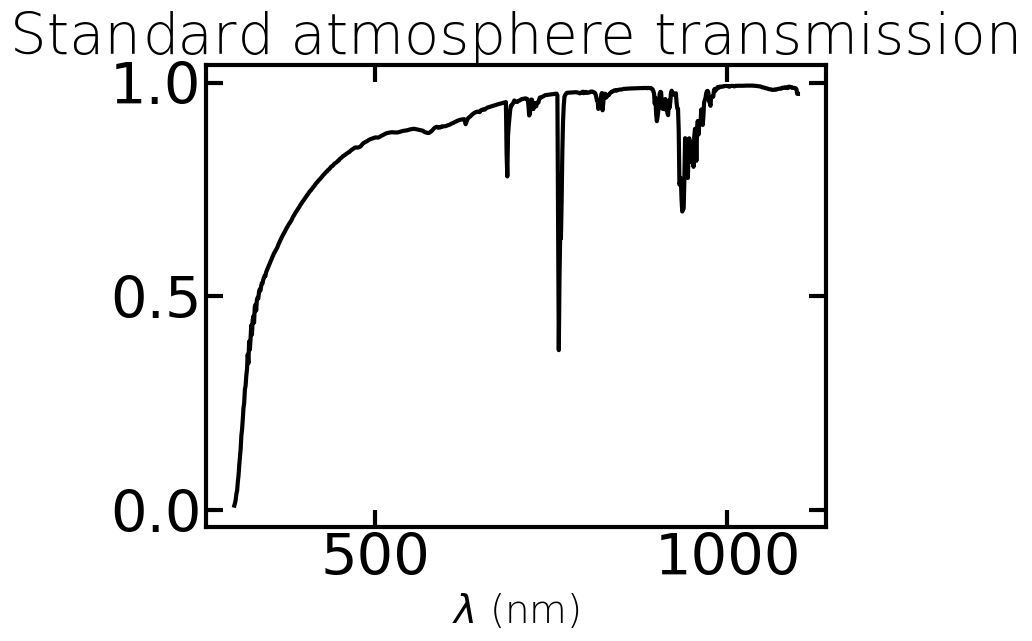

In [25]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

## Pickup an SED

In [26]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [27]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar','photoZ_outliers'] 
sedtypes_not_used = ['stars', 'white_dwarf','sn']
sedtypes = sedtypes 

NSEDTYPES = len(sedtypes)

# dictionnary indexed by sed-name
seds = {}      # dictionnary that will contain the `rubin_sim` seds-Flambdas
sedsfnu = {}   # dictionnary that will contain the `rubin_sim` seds-Fnu
sedtypeslists = {}  # dictionnary that contain the SED type
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].read_sed_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        


In [28]:
df_SED=df_SED.set_index('name')
df_SED

,type
name,
Sa_template_norm,galaxies
Ell2_template_norm,galaxies
Sdm_template_norm0,galaxies
quasar,quasar
xspec_172,photoZ_outliers
xspec_90,photoZ_outliers
xspec_173,photoZ_outliers
xspec_91,photoZ_outliers
xspec_176,photoZ_outliers


In [29]:
sed_name = 'xspec_90'
#sed_name = 'xspec_91'
#sed_name = 'xspec_172'
#sed_name = 'xspec_173'
#sed_name = 'xspec_175'
#sed_name = 'xspec_176'
#sed_name = 'quasar'
#sed_name = 'Sa_template_norm'
#sed_name = 'Sdm_template_norm0'
#sed_name = 'Ell2_template_norm'
#sed_name = 'sn1a_10.0'
#sed_name = 'sn1a_15.0'
#sed_name = 'sn1a_20.0'

In [30]:
z=0
seds[sed_name].redshift_sed(z)

In [31]:
# Scale spectrum and recalculate magnitudes.
y = 20.0

flux_norm = seds[sed_name].calc_flux_norm(y, pc.bandpass_total_std['y'])
seds[sed_name].multiply_flux_norm(flux_norm)

## Simulate a few redshifts

In [32]:
renorm_mag_inY = 20

all_redshifts = np.arange(0,3.5,0.5)
all_seds = []
all_seds_name = []
NSEDS = len(all_redshifts)
hls_colors = sns.color_palette("hls", NSEDS)
for idx,z in enumerate(all_redshifts):
    the_sed = copy.deepcopy(seds[sed_name])
    the_sed.redshift_sed(z)
    
    # Scale spectrum and recalculate magnitudes.
    flux_norm = the_sed.calc_flux_norm(renorm_mag_inY, pc.bandpass_total_std['y'])
    the_sed.multiply_flux_norm(flux_norm)

    #flux_norm = the_sed.calc_flux_norm(g, pc.bandpass_total_std['g'])
    #the_sed.multiply_flux_norm(flux_norm)
    the_sed_name = f"{sed_name}_{idx}_z{z:.1f}"
    all_seds.append(copy.deepcopy(the_sed))
    
    all_seds_name.append(the_sed_name)

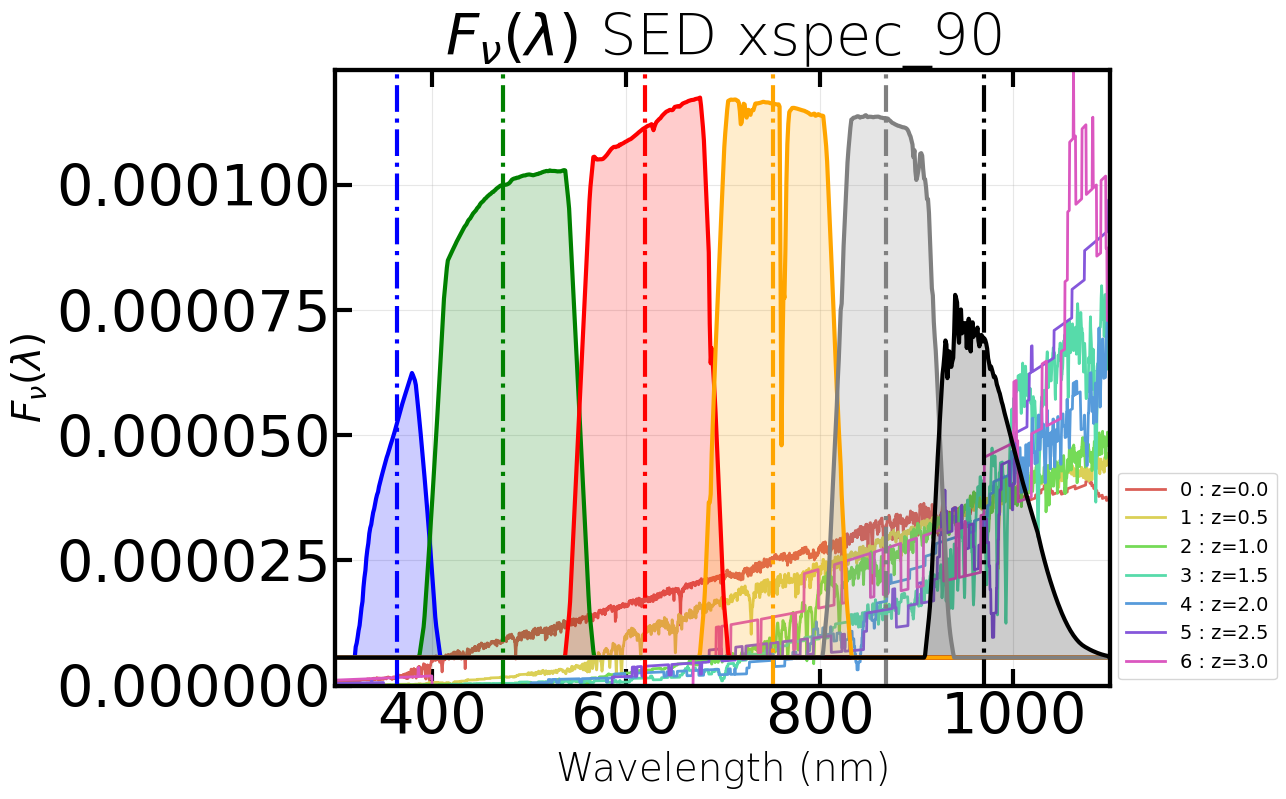

In [33]:
# Plot the seds
all_fmax = np.zeros(NSEDS)
fig, ax = plt.subplots(1,1,figsize=(10,8))

for idx,the_sed in enumerate(all_seds):
    
    wavel,fnu = the_sed.get_sed_fnu()
    z=all_redshifts[idx] 
    label = f"{idx} : z={z:.1f}"
    
    ax.plot(wavel, fnu,"-",color=hls_colors[idx],label=label,lw=2)
    
    indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
    flmax = np.max(fnu[indexes_sel])
    all_fmax[idx] = flmax
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
fmax=np.max(all_fmax)
ax.set_ylim(0,fmax)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$" + f" SED {sed_name}")

indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
flmax = np.max(fnu[indexes_sel])

                       

ax2 = ax.twinx()
for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

# Calculations of magnitude in standard passband

In [34]:
mags_std = {}
for index,f in enumerate(filter_tagnames) :
    mags_std[f] = seds[sed_name].calc_mag(pc.bandpass_total_std[f])
    
pd.DataFrame(mags_std, index=[sed_name]).T

,xspec_90
u,23.070980
g,21.526727
r,20.808852
i,20.422447
z,20.153588
y,20.000000


## Read Test data

In [35]:
filename_data_zspeczphot1 = f"data_zspeczphot_{sed_name}_normMagY_{renorm_mag_inY}_v1.csv"
df1 = pd.read_csv(filename_data_zspeczphot1)
                  
filename_data_zspeczphot2 = f"data_zspeczphot_{sed_name}_normMagY_{renorm_mag_inY}_v2.csv"
df1 = pd.read_csv(filename_data_zspeczphot2)



In [36]:
df1

,Unnamed: 0,zspec,zphot
0,0,1.357270,1.365850
1,1,2.668806,2.659641
2,2,2.088321,2.099369
3,3,2.866825,2.858367
4,4,2.371539,2.359073
...,...,...,...
19995,19995,2.471514,2.455993
19996,19996,2.412725,2.403361
19997,19997,2.223980,2.224065
19998,19998,2.753293,2.734340


In [37]:
zspec = df1["zspec"]
zphot = df1["zphot"]

In [38]:
zspec

0        1.357270
1        2.668806
2        2.088321
3        2.866825
4        2.371539
           ...   
19995    2.471514
19996    2.412725
19997    2.223980
19998    2.753293
19999    0.724754
Name: zspec, Length: 20000, dtype: float64

### Performances

In [39]:
nmad,std_result,bias,eta,stats_txt2= get_stats(zspec,zphot)

Standard Deviation: 0.0495
Normalized MAD: 0.0044
Delta z >0.15(1+z) outliers:  2.100 percent
Median offset:  0.002 +/-  0.000


### Plot

Standard Deviation: 0.0495
Normalized MAD: 0.0044
Delta z >0.15(1+z) outliers:  2.100 percent
Median offset:  0.002 +/-  0.000
ax is None


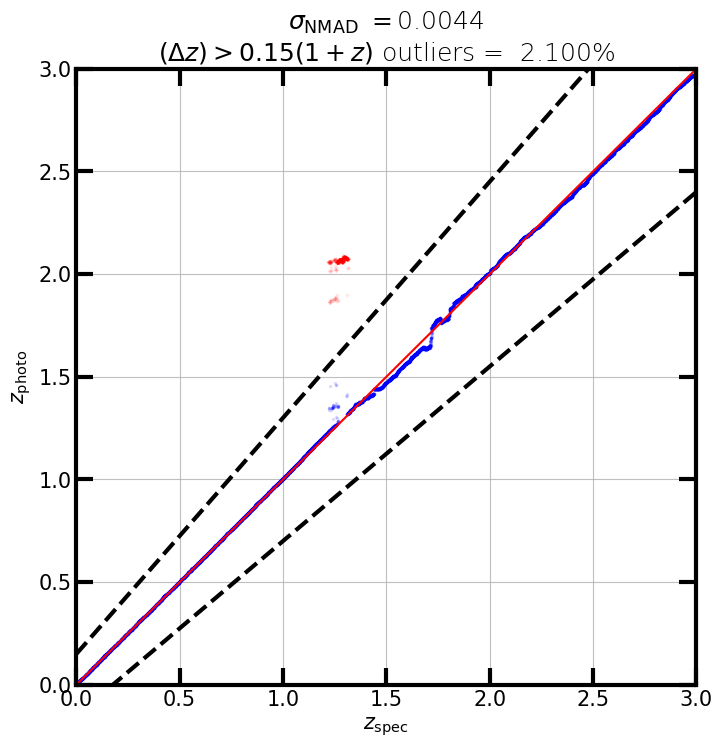

In [40]:
plot_and_stats(zspec,zphot,ax=None)

In [41]:
#zphot= y_pred
#zspec = y_test
num = zphot-zspec
dnom = (1.+zspec)
DZZ = num/dnom

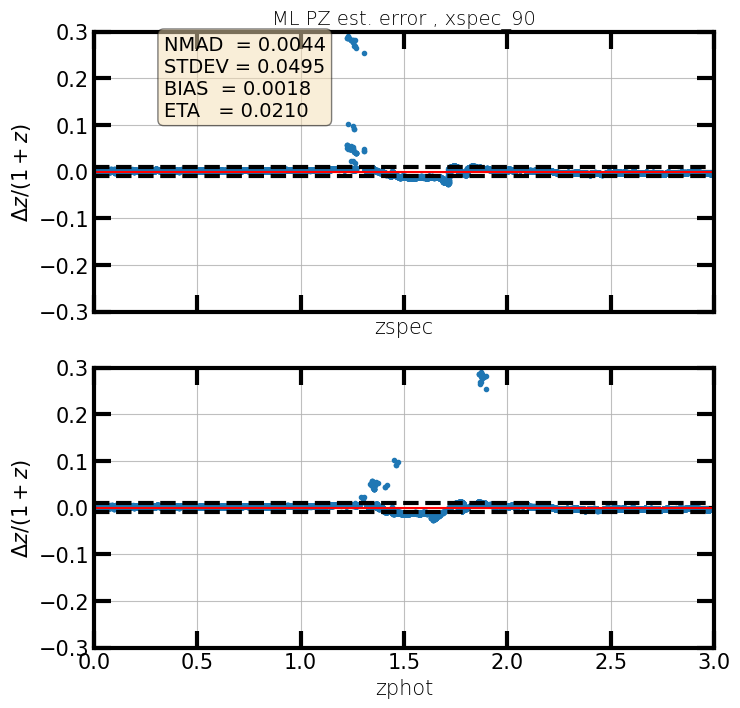

In [42]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),sharex=True)
ax1.text(0.05, 0.95, stats_txt2, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax1.plot(zspec,DZZ,'.')
ax1.set_title(f"ML PZ est. error , {sed_name}",fontsize=14)
plotdzvsz(ax1,xlabel="zspec")
ax2.plot(zphot,DZZ,'.')
plotdzvsz(ax2,xlabel="zphot")

In [46]:
renorm_mag_inI = 20

if sed_name == 'xspec_90':
    all_redshifts = [0.,1.3,2.]
else:
    all_redshifts = [0.,1.5,2.]
all_seds = []
all_seds_name = []
NSEDS = len(all_redshifts)
hls_colors = sns.color_palette("hls", NSEDS)
for idx,z in enumerate(all_redshifts):
    the_sed = copy.deepcopy(seds[sed_name])
    the_sed.redshift_sed(z)
    
    # Scale spectrum and recalculate magnitudes.
    flux_norm = the_sed.calc_flux_norm(renorm_mag_inI , pc.bandpass_total_std['i'])
    the_sed.multiply_flux_norm(flux_norm)

    #flux_norm = the_sed.calc_flux_norm(g, pc.bandpass_total_std['g'])
    #the_sed.multiply_flux_norm(flux_norm)
    the_sed_name = f"{sed_name}_{idx}_z{z:.1f}"
    all_seds.append(copy.deepcopy(the_sed))
    
    all_seds_name.append(the_sed_name)

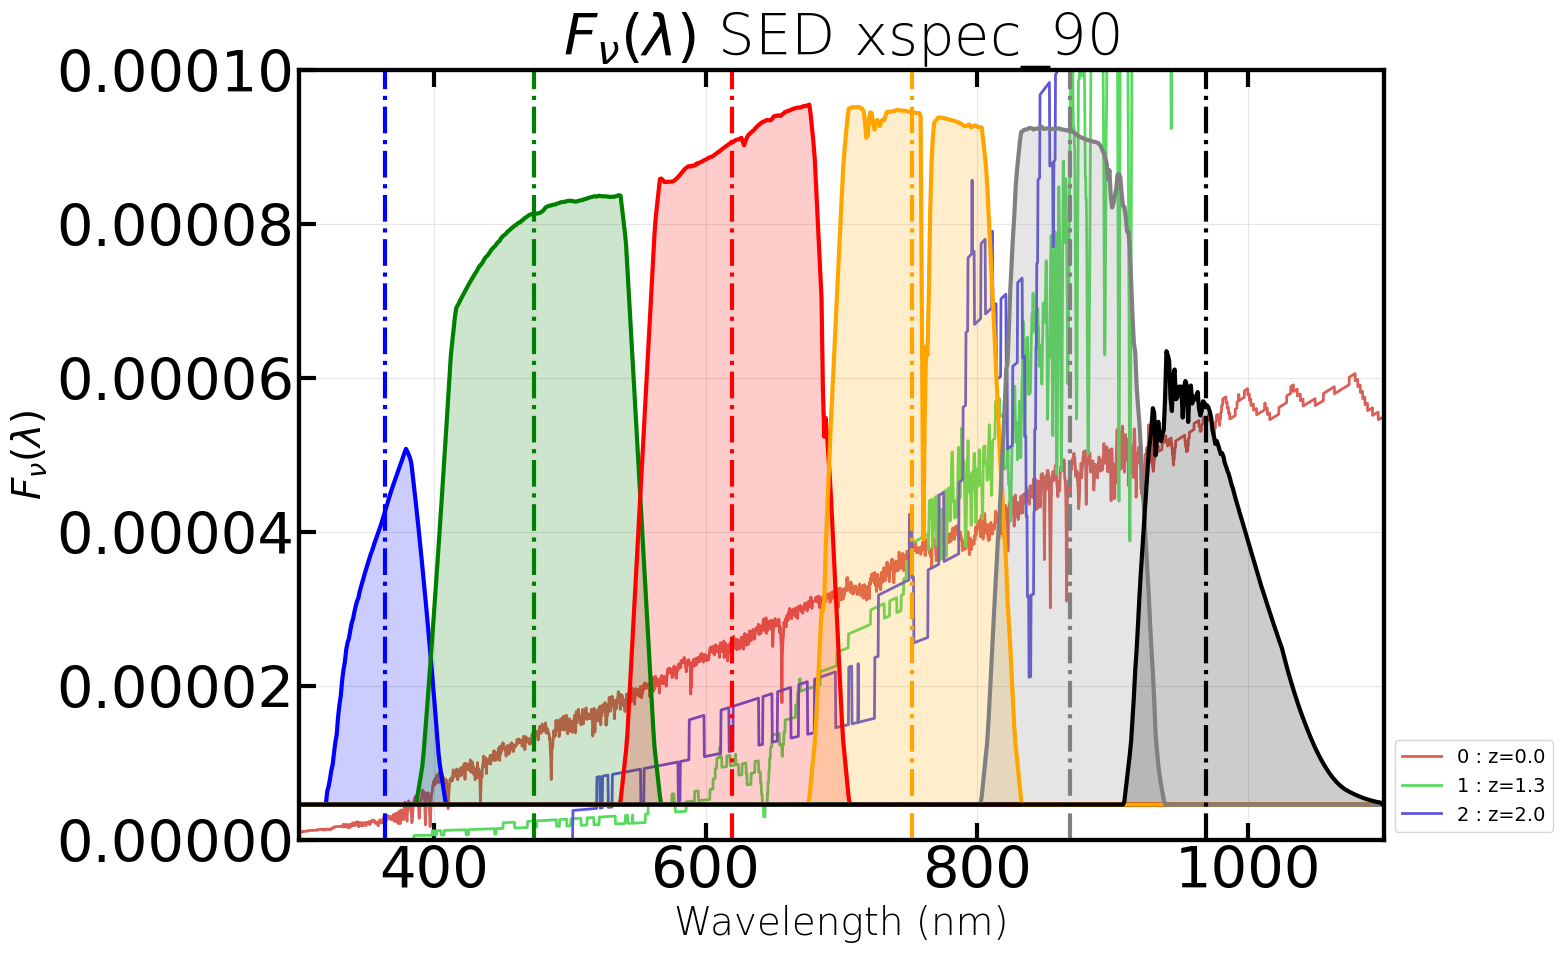

In [47]:
# Plot the seds
all_fmax = np.zeros(NSEDS)
fig, ax = plt.subplots(1,1,figsize=(14,10))

for idx,the_sed in enumerate(all_seds):
    
    wavel,fnu = the_sed.get_sed_fnu()
    z=all_redshifts[idx] 
    label = f"{idx} : z={z:.1f}"
    
    ax.plot(wavel, fnu,"-",color=hls_colors[idx],label=label,lw=2)
    
    indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
    flmax = np.max(fnu[indexes_sel])
    all_fmax[idx] = flmax
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
fmax=np.max(all_fmax)
ax.set_ylim(0,fmax)
ax.set_ylim(0,1e-4)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$" + f" SED {sed_name}")

indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
flmax = np.max(fnu[indexes_sel])

                       

ax2 = ax.twinx()
for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    